In [1]:
from scipy.stats import binom, norm
from scipy.integrate import cumulative_trapezoid
import numpy as np
import matplotlib.pyplot as plt

# Introduction to Bayesian Statistics
Notes used:  
https://kipac.github.io/StatisticalMethods/notes/credible_regions.html  
https://statswithr.github.io/book/the-basics-of-bayesian-statistics.html#frequentist-vs.-bayesian-inference

## Bayes' Theorem
Bayesian Statistics allows us to calculate conditional probabilities, generally framed as the probability of a certain hypothesis given an observation/dataset and some prior beliefs we hold for the probability of the hypothesis we want to test. To do this, we use Bayes' Theorem:
$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$
- P(A) is the prior probability that we assign for hypothesis $A$.
- P(B|A) is the likelihood of the data $B$ given the hypothesis $A$.
- P(B) is the evidence for the data given all possible hypotheses.
- P(A|B) is the posterior probability for the hypothesis $A$.

### Example: Outdoor dining
Let's look at an example. Our favorite restaurant has opened their patio for the season. If it's sunny, there's a 75% chance that the patio is open (it might be closed for private events or due to limited staff availability). If it's raining, the patio is always closed. On average in our area, 60% of days are sunny. What is the probability of it being sunny if we know the patio is closed?

What we know:  
p(patio | sun) = 0.75  
p(patio | rain) = 0  
p(sun) = 0.6  
p(rain) = 1-0.6=0.4  

Calculate evidence:  
p(patio) = p(patio|sun)p(sun) + p(patio|rain)p(rain)  
p(patio) = 0.75 x 0.6 + 0 x 0.4 = 0.45  
p(nopatio) = p(nopatio|sun)p(sun) + p(nopatio|rain)p(rain)  
p(nopatio) = (1-0.75) x 0.6 + 1 * 0.4 = 0.55  
p(patio) + p(nopatio) = 1  

Calculate posterior:  
p(sun | nopatio) = p(nopatio|sun) x p(sun)/p(nopatio)  
p(sun | nopatio) = (1-0.75) x 0.6/0.55 = 0.273  

What about the other three possibilities?

## Frequentist vs Bayesian Statistics
Frequentist statisticians calculate probabilities based on a large number of trials of the same experiment:
$p(A) = \lim_{n\rightarrow \infty}\frac{n_{A}}{n},$ while Bayesian statisticians calculate the same probability by incorporating and updating their prior beliefs. Let's see how these two different methods compare for the same problem.

For your statistics class, you want to know if reading the textbook is an effective way to study for the exam. You look at last year's results, where students were asked whether they read the textbook upon completion of the exam. In a class of 40 students, half read the textbook and the other half did not. Of the half that did, 16/20 passed the exam, while only 4/20 did for the half that did not. Assume that reading the textbook is the only element of exam preparation that varied between the two groups. Will reading the textbook help you pass the class?

### Frequentist Approach

Because we have equal number of students that did and did not read the textbook, we can focus only on those that did pass the exam. We can model this as a [Bernoulli process](https://en.wikipedia.org/wiki/Bernoulli_process#:~:text=In%20probability%20and%20statistics%2C%20a,are%20identically%20distributed%20and%20independent.), because there are only two outcomes: the passing student did or did not read the textbook. The probability of observing $k$ successes given $n$ total trials for a Bernoulli process is given by a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution),
$$p(k | n, p) = \begin{pmatrix} n \\ k \end{pmatrix}p^k(1-p)(n-k),$$
where $p$ is the probability of success. The "null hypothesis" that we want to rule out is that it's equally likely for a passing student to have read or not read the textbook, $p=0.5$. We can estimate the number of passing students that did not read the textbook given $n=20$ and $p=0.5$.

Text(0.5, 1.0, '$p_{\\mathrm{pass}}=0.5,\\ n_{\\mathrm{trials}}=20$')

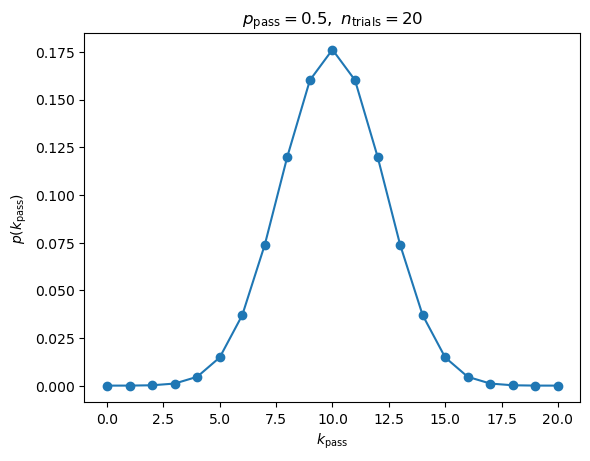

In [2]:
x = range(0, 21)
plt.plot(x, binom.pmf(x, n=20, p=0.5), marker='o')
plt.xlabel(r'$k_{\mathrm{pass}}$')
plt.ylabel(r'$p(k_{\mathrm{pass}})$')
plt.title(r'$p_{\mathrm{pass}}=0.5,\ n_{\mathrm{trials}}=20$')

While $k=10$ is the expected value for the null hypothesis, we measured $k=4$. To rule out the null hypothesis, we need to calculate a **p-value** to quantify how likely it is to obtain an outcome that is at least as extreme as the one we obtained. To this end, we want to quantify the probability that we would observe four or fewer passes from the no-textbook group out of 20 total passes. 

In [3]:
pvalue = np.sum(binom.pmf(range(0, 5), n=20, p=0.5))
print(1/pvalue)

169.234344738541


This means that only one of out 169 repetitions of the 20-trial experiment would result in 4 passes coming from the no-textbook group, which is very unlikely, so the null hypothesis is ruled out. Note that we get the same p-value if we calculate the inverse problem: the probability that we would observe 16 or more passes from the textbook group.

In [4]:
np.sum(binom.pmf(range(0, 5), n=20, p=0.5))
np.sum(binom.pmf(range(16,21), n=20, p=0.5))

0.005908966064453125

### Bayesian approach

We want to constrain $p$, the probability that a student who passed the test read the textbook. We start with the assumption that all values of $p$ are equally likely, a uniform prior:

In [5]:
m = 200
p = np.linspace(0, 1, m)
uniform_prior = np.ones(m)

Likelihood is $p(\mathrm{data} | \mathrm{model}) = P(k=16 | n=20, p)$  

In [6]:
likelihood_tb = []
for i in p:
    likelihood_tb.append(binom.pmf(16, n=20, p=i))

Now we need to calculate the posterior, $p(p | \mathrm{data}) \propto p(\mathrm{data} | p)p(p)$

In [7]:
posterior_unif = likelihood_tb * uniform_prior

(0.0, 1.0)

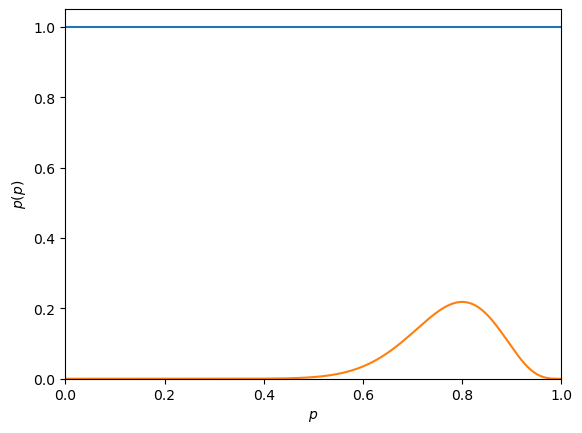

In [8]:
plt.plot(p, uniform_prior)
plt.plot(p, posterior_unif)
plt.xlabel(r'$p$')
plt.ylabel(r'$p(p)$')
plt.ylim(0,)
plt.xlim(0,1)

You can see that the posterior is not normalized. Let's now calculate the evidence:

In [9]:
evidence_unif = np.trapz(posterior_unif, p)
posterior_unif /= evidence_unif

(0.0, 1.0)

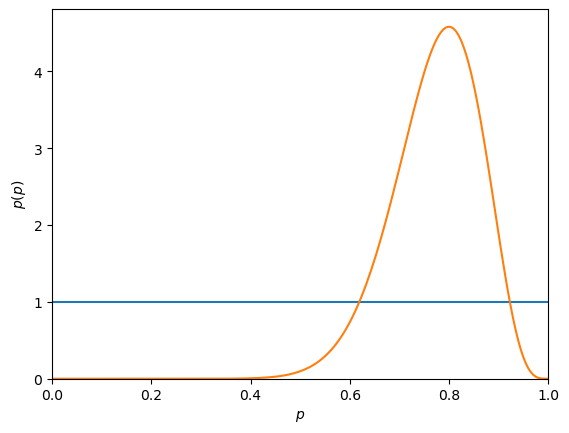

In [10]:
plt.plot(p, uniform_prior)
plt.plot(p, posterior_unif)
plt.xlabel(r'$p$')
plt.ylabel(r'$p(p)$')
plt.ylim(0,)
plt.xlim(0,1)

We can see that the posterior on the probability that a student who passed the test read the textbook peaks around $p\sim 16/20 = 0.8$. Let's calculate the maximum posterior value of $p$:

In [11]:
maxp = p[np.argmax(posterior_unif)]
print(maxp)

0.7989949748743719


We can also calculate the 90% credible interval on $p$. This is defined as the smallest continuous probability region including the maximum posterior value that includes 90% of the posterior probability. There are multiple ways to calculate this. Let's start by using a symmetric credible interval, which assumes that the probability distribution is symmetric about the maximum. To do this, it's convenient to first calculate the cumulative density function:
$$\mathrm{CDF}(p) = \int_{p_{\min}}^{p} p(p')dp'$$

In [12]:
cdf_unif = cumulative_trapezoid(posterior_unif, p, initial=0)

(0.0, 1.0)

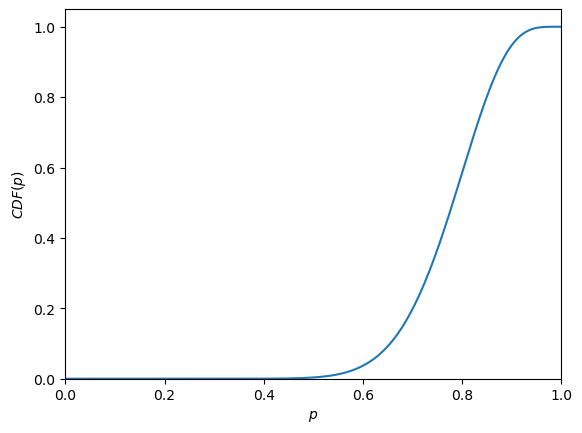

In [97]:
plt.plot(p, cdf_unif)
plt.xlabel(r'$p$')
plt.ylabel(r'$CDF(p)$')
plt.ylim(0,)
plt.xlim(0,1)

Now we define the minimum of the 90% symmetric credible interval as the value of $p$ where $\mathrm{CDF}(p)=0.05$, and the maxmimum where $\mathrm{CDF}(p)=0.95$.

In [98]:
min_loc = np.argmin(abs(cdf_unif-0.05))
max_loc = np.argmin(abs(cdf_unif-0.95))
ci_symmetric_min = p[min_loc]
ci_symmetric_max = p[max_loc]
print(rf'p={maxp:.2f}+{(ci_symmetric_max-maxp):.2f}-{(maxp-ci_symmetric_min):.2f}')

p=0.80+0.10-0.19


(0.0, 1.0)

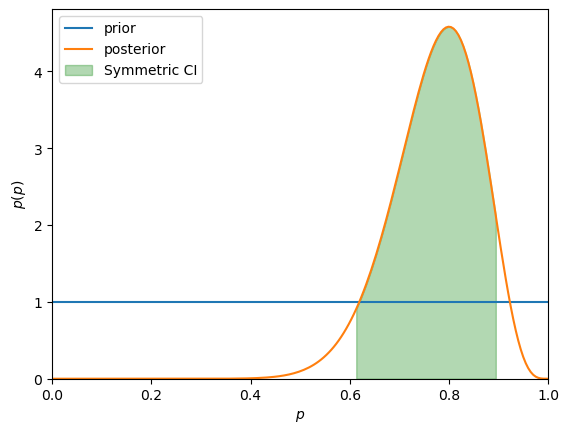

In [99]:
plt.plot(p, uniform_prior, label='prior')
plt.plot(p, posterior_unif, label='posterior')
plt.fill_between(p[min_loc:max_loc], posterior_unif[min_loc:max_loc], alpha=0.3, color='green', label='Symmetric CI')
plt.xlabel(r'$p$')
plt.ylabel(r'$p(p)$')
plt.legend()
plt.ylim(0,)
plt.xlim(0,1)

In [100]:
# verify the probability for the symmetric credible interval
area_symmetric = np.trapz(posterior_unif[min_loc:max_loc], p[min_loc:max_loc])
print(area_symmetric)

0.889004041969274


We can also calculate the Higest Posterior Density credible interval, which is a much better choice when the distribution is highly assymetric or multi-modal. The procedure for calculating the HPD CI is:
- Choose some initial threshold value of the posterior probability density.
- Integrate the posterior PDF within the interval(s) where it exceeds the threshold.
- Repeat the last step, decreasing the threshold density until the integral corresponds to the CI we are trying to estimate (i.e., 90% = 0.9)

In [101]:
area = 0
ci = 0.9
posterior_max = max(posterior_unif)
dprob = max(min(abs(posterior_unif[1:]-posterior_unif[:-1])), 1e-3)
inds = []
while area < ci: 
    posterior_max -= dprob
    inds = np.where(posterior_unif > posterior_max)[0]
    area = np.trapz(posterior_unif[inds], p[inds])
ci_hpd_min = min(p[inds])
ci_hpd_max = max(p[inds])
print(rf'p={maxp:.2f}+{(ci_hpd_max-maxp):.2f}-{(maxp-ci_hpd_min):.2f}')

p=0.80+0.12-0.17


In [102]:
# verify the probability for the HPD credible interval
print(area)

0.9018313879373742


(0.0, 1.0)

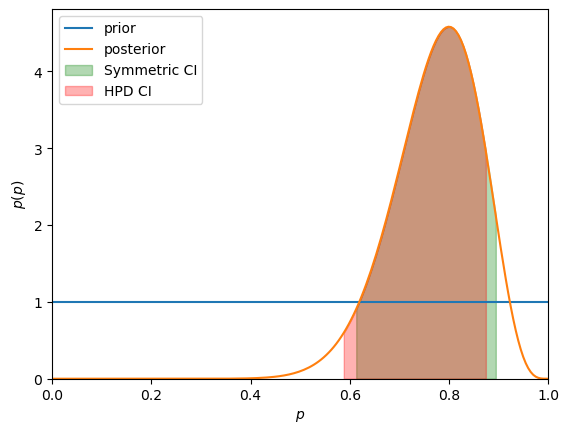

In [136]:
plt.plot(p, uniform_prior, label='prior')
plt.plot(p, posterior_unif, label='posterior')
plt.fill_between(p[min_loc:max_loc], posterior_unif[min_loc:max_loc], alpha=0.3, color='green', label='Symmetric CI')
plt.fill_between(p[inds], posterior_unif[inds], alpha=0.3, color='red', label='HPD CI')
plt.xlabel(r'$p$')
plt.ylabel(r'$p(p)$')
plt.legend()
plt.ylim(0,)
plt.xlim(0,1)

We can see that the credible intervals are different because the posterior is not symmetric. Now, we want to return to the original question: what is the probability that reading the textbook is an effective study method? Remember that the null hypothesis is that students who did and did not read the textbook are equally likely to pass the test. To answer our original question, we can calculate the total probability for $p>0.5$, meaning that students who passed the test are more likely to have read the textbook.

In [104]:
inds = np.where(p>0.5)[0]
prob_effective = np.trapz(posterior_unif[inds], p[inds])
print(prob_effective)
print(1-prob_effective)

0.9961448731668813
0.003855126833118727


This is similar to, but not exactly equal to the significance we obtained using the frequentist approach.

### A note on p-values and "sigmas"
The significance of a measurement/finding is often reported in terms of sigmas, with $5\sigma$ being the gold standard for an unambiguously significant measurement. Now that we've introduced credible intervals, we can calculate what is the significance of our p-value in sigmas? In this case, "N-sigma" refers to the number of standard deviations of a Gaussian that encompass the probability density given by $1 - p_{\mathrm{value}}$.

In [105]:
area1 = 1-pvalue
print(area1)
x = np.linspace(-5, 5, 100000)
probx = norm.pdf(x)
cdfx = cumulative_trapezoid(probx, x, initial=0)
ind = np.argmin(abs(cdfx-pvalue/2))
sigma = abs(x[ind])
print(sigma)

0.9940910339355469
2.7527775277752777


## A more data-driven example

In the previous example, we only had one data point: that 16 of the 20 students who passed the test had read the textbook. Let's now look at a series of data points that should be more familiar in an astronomical context: a timeseries that contains a linear signal that we want to characterize.

In [106]:
# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c

In [107]:
# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=0.5, c=0.2)

# For this example, we'll inject standard Gaussian noise
sigma = 1

# These lines of code generate the fake data. Note the ** just unpacks the
# contents of the injection_parameters when calling the model function.
sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
np.random.seed(1995)
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

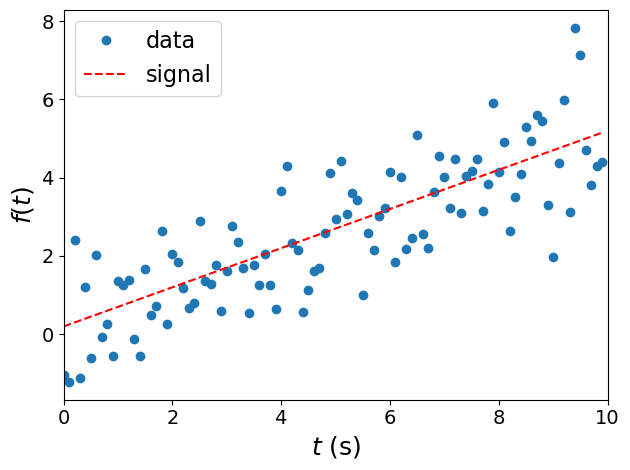

In [108]:
# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("$t$ (s)", fontsize=18)
ax.set_ylabel("$f(t)$", fontsize=18)
ax.set_xlim(0,10)
ax.legend(fontsize=16)
plt.tight_layout()

Because we have simulated Gaussian noise, our likelihood is Gaussian:
$$p(d | m, c) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp{-\frac{(d(t) - h(t; m, c))^2}{2\sigma^2}}\\
h(t; m,c) = mt + c$$
We assume that the properties of the noise ($\sigma=1$) are known for now, but they can also be estimated from the data. You will try this tomorrow. We also assume that each data point is independent, allowing us to write the total likelihood as the produce of the likelihood for each data point:
$$p(\{d\} | m, c) = \prod_{t} \frac{1}{\sqrt{2\pi\sigma^2}}\exp{-\frac{(d(t) - h(t; m, c))^2}{2\sigma^2}}$$

In [109]:
def likelihood(data, time, m, c, sigma):
    likelihood_arr = 1./np.sqrt(2*np.pi*sigma**2)*np.exp(-(data - model(time, m, c))**2/(2*sigma**2))
    return np.prod(likelihood_arr)

Now, we want to calculate the posterior on $m, c$ given the `data` we have generated above. We will assume uniform priors, so that posterior $\propto$ likelihood for simplicity. We can calculate the likelihood on a grid of values for $m,c$.

In [110]:
ms = np.linspace(0.35, 0.65, 100)
cs = np.linspace(-0.7, 1, 99)
dm = ms[1]-ms[0]
dc = cs[1]-cs[0]
prior_m = 1./(ms[-1]-ms[0])
prior_c = 1./(cs[-1]-cs[0])

In [111]:
likelihoods = []
for m in ms:
    for c in cs:
        likelihoods.append(likelihood(data, time, m, c, 1))
likelihoods = np.array(likelihoods).reshape(len(ms), len(cs))

Calculate the evidence and 2D posterior

In [112]:
posterior = likelihoods*prior_m*prior_c
evidence = np.trapz(np.trapz(posterior, cs, axis=1), ms)
posterior /= evidence
print(np.log(evidence))

-151.78336733507027


Before we plot the full 2D posterior, let's calculate the marginalized 1D posteriors, $$p(m|d) = \int p(m, c|d)dc,\\ p(c | d) = \int p(m, c|d)dm$$

In [113]:
post_m = np.trapz(posterior, cs, axis=1)
post_c = np.trapz(posterior, ms, axis=0)

Now we are ready to plot the full posterior. Multi-dimensional posteriors are typically visualized using **corner plots**, which include a grid of $N\times N$ individual panel, where the diagonal shows the marginalized 1D posteriors for each parameters, and the other panels below the diagonal only (hence, "corner") show the 2D posteriors for pairs of parameters. How do we visualize a 2D posterior? We plot the contours the enclose a certain total probability (remembering that the total encolsed probability =1). Here, we will plot the 50% and 90% 2D credible regions.

In [114]:
def calc_L90_L50(dx, dy, fx):
        fx_flat = np.ravel(fx).copy()
        fx_flat.sort()
        fx_flat[:] = fx_flat[::-1]
        cdf = np.cumsum(fx_flat)*dx*dy
        cdf /= max(cdf)
        nearest_90 = np.argmin(abs(cdf-0.9))
        nearest_50 = np.argmin(abs(cdf-0.5))
        l90 = fx_flat[nearest_90]
        l50 = fx_flat[nearest_50]
        lmax = fx_flat[0]
        return lmax, l50, l90 

In [115]:
lmax, l50, l90 = calc_L90_L50(dm, dc, posterior)

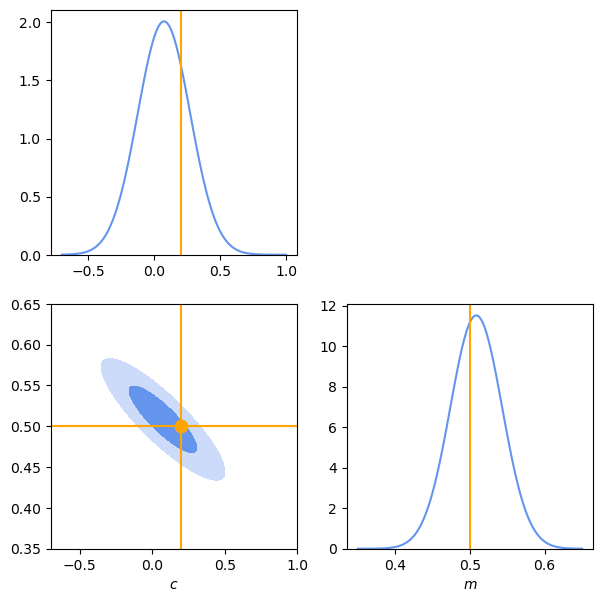

In [116]:
fig, axes = plt.subplots(2,2, figsize=(7,7))
axes[1,1].plot(ms, post_m, color='cornflowerblue')
axes[1,1].set_ylim(0,)
axes[1,1].axvline(injection_parameters['m'], color='orange')
axes[0,0].plot(cs, post_c, color='cornflowerblue')
axes[0,0].set_ylim(0,)
axes[0,0].axvline(injection_parameters['c'], color='orange')
axes[1,0].contourf(cs, ms, posterior, levels=[l90, l50, lmax], colors=['#CBDBF9', '#6495ED'])
axes[1,0].set_xlabel(r'$c$')
axes[1,0].axvline(injection_parameters['c'], color='orange')
axes[1,0].axhline(injection_parameters['m'], color='orange')
axes[1,0].scatter(injection_parameters['c'], injection_parameters['m'], s=80, color='orange')
axes[1,1].set_xlabel(r'$m$')
axes[0,1].remove()

### Problem 1: Epidemiology
A new viral pandemic has broken out, and a rapid test is available to determine if you are infected. Currently, 0.2% of the US population is infected. The test has a false positive rate of $p(+ | \mathrm{not\ sick}) = 0.01$, and a true positive rate of $p(+ | \mathrm{sick}) = 0.93$. Calculate: 
 - The probability that you're sick if you test positive
 - The probability that you're sick if you test negative
 - The probability that you're not sick if you test positive
 - The probability that you're not sick if you test negative
 - The probability that you're sick after testing positive twice? Hint: assume that the correctness of the second test is independent of the first test, and think about "updating your prior".

In [117]:
# The probability that you're sick if you test positive

# p(sick | +) = p(+ | sick) * p(sick) / p(+)

# p(sick) = 0.002
# -> p(not sick) = 0.998
# p(+) = p(+|sick)p(sick) + p(+|not sick)p(not sick)
p_sick, p_notsick = 0.002, 0.998
p_pos_notsick = 0.01
p_pos_sick = 0.93
p_pos = (p_pos_sick * p_sick) + (p_pos_notsick * p_notsick)

p_sick_pos = (p_pos_sick * p_sick) / p_pos
print(f"The probability that you're sick if you test positive: {p_sick_pos}")

The probability that you're sick if you test positive: 0.15709459459459457


In [118]:
# The probability that you're sick if you test negative

# p(sick | -) = p(- | sick) * p(sick) / p(-)
# p(-) = p(-|sick)p(sick) + p(-|not sick)p(not sick)

p_sick, p_notsick = 0.002, 0.998 # same as before
p_neg_notsick = 1 - p_pos_notsick
p_neg_sick = 1 - p_pos_sick
p_neg = (p_neg_sick * p_sick) + (p_neg_notsick * p_notsick)

p_sick_neg = (p_neg_sick * p_sick) / p_neg
print(f"The probability that you're sick if you test negative: {p_sick_neg}")

The probability that you're sick if you test negative: 0.00014167746113989628


In [119]:
# The probability that you're not sick if you test positive

# p(not sick | +) = p(+ | not sick) * p(not sick) / p(+)
p_notsick_pos = (p_pos_notsick * p_notsick) / p_pos
print(f"The probability that you're not sick if you test positive: {p_notsick_pos}")

The probability that you're not sick if you test positive: 0.8429054054054054


In [120]:
p_sick_pos + p_notsick_pos # nice

1.0

In [121]:
# The probability that you're not sick if you test negative

# p(not sick | -) = p(- | not sick) * p(not sick) / p(-)
p_notsick_neg = (p_neg_notsick * p_notsick) / p_neg
print(f"The probability that you're not sick if you test positive: {p_notsick_neg}")

The probability that you're not sick if you test positive: 0.9998583225388601


In [122]:
# The probability that you're sick after testing positive twice?
## Hint: assume that the correctness of the second test is independent of the first test, 
## and think about "updating your prior".


# p(sick|+1) <- this should become prior P(A) when calculating p(sick|+2)

p_sick_pos1 = (p_pos_sick * p_sick) / p_pos
print(f"I have a positive covid test. P(sick|pos_test1) = {p_sick_pos1}")
p_pos2 = (p_pos_sick * p_sick_pos1) + (p_pos_notsick * (1 - p_sick_pos1))
p_sick_pos2 = (p_pos_sick * (p_sick_pos1)) / p_pos2
print(f"I have a SECOND positive covid test. P(sick|pos_test2) = {p_sick_pos2}")

I have a positive covid test. P(sick|pos_test1) = 0.15709459459459457
I have a SECOND positive covid test. P(sick|pos_test2) = 0.9454525579361609


### Problem 2: Prior effects 
Change the prior used on $p$ for the textbook example to a truncated Gaussian distribution with mean $\mu=0.5, \sigma=0.2$ with $p\in[0,1]$ and recalculate the probability that a student who passed the test used a textbook (maximum posterior value and 90% credible interval) and the probability that the textbook is an effective study tool for passing the test. Which is the better prior choice, uniform or Gaussian centered on $p=0.5$, given the null hypothesis that we originally considered?

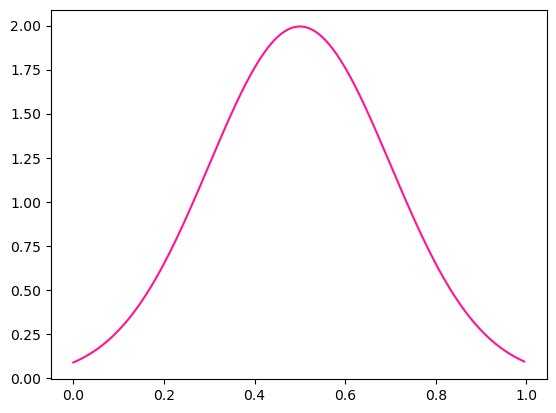

In [128]:
x_rng = np.arange(0,1, 1/200)
gauss_prior = norm.pdf(x_rng, loc=0.5, scale = 0.2)
plt.plot(x_rng, gauss_prior, c='deeppink')

In [129]:
posterior_gauss = likelihood_tb * gauss_prior

evidence_gauss = np.trapz(posterior_gauss, x_rng)
posterior_gauss /= evidence_gauss

maximum posterior value: 0.74


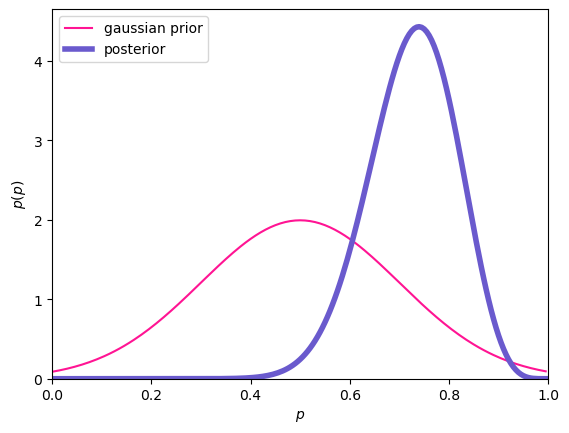

In [131]:
plt.plot(x_rng, gauss_prior, c='deeppink', label='gaussian prior')
plt.plot(x_rng, posterior_gauss, c='slateblue', lw=4, label='posterior')
plt.xlabel(r'$p$')
plt.ylabel(r'$p(p)$')
plt.ylim(0,)
plt.xlim(0,1)
plt.legend()

np.argmax(posterior_gauss)
print(f"maximum posterior value: {x_rng[np.argmax(posterior_gauss)]}")

In [126]:
# recalculate the 90% credible interval) and the probability that 
# the textbook is an effective study tool for passing the test. Which is the better prior choice,
# uniform or Gaussian centered on $p=0.5$, given the null hypothesis that we originally considered?

p=0.80+0.07-0.21
0.900915985166477


(0.0, 1.0)

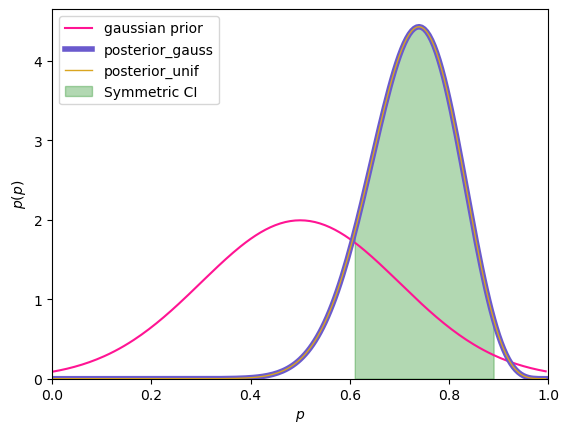

In [135]:
area = 0
ci = 0.9
posterior_max = max(posterior_gauss)
dprob = max(min(abs(posterior_gauss[1:]-posterior_gauss[:-1])), 1e-3)
inds = []
while area < ci: 
    posterior_max -= dprob
    inds = np.where(posterior_gauss > posterior_max)[0]
    area = np.trapz(posterior_gauss[inds], p[inds])
ci_hpd_min = min(x_rng[inds])
ci_hpd_max = max(x_rng[inds])
print(rf'p={maxp:.2f}+{(ci_hpd_max-maxp):.2f}-{(maxp-ci_hpd_min):.2f}')

# verify the probability for the HPD credible interval
print(area)

plt.plot(x_rng, gauss_prior, c='deeppink', label='gaussian prior')
plt.plot(x_rng, posterior_gauss, c='slateblue', lw=4, label='posterior_gauss')
plt.plot(x_rng, posterior_gauss, c='goldenrod', lw=1, label='posterior_unif')
plt.fill_between(x_rng[min_loc:max_loc], posterior_gauss[min_loc:max_loc], alpha=0.3, color='green', label='Symmetric CI')
#plt.fill_between(p[inds], posterior_gauss[inds], alpha=0.3, color='red', label='HPD CI')
plt.xlabel(r'$p$')
plt.ylabel(r'$p(p)$')
plt.legend()
plt.ylim(0,)
plt.xlim(0,1)

### Problem 3: Credible intervals
Calculate the 90% credible interval for $m$ and $c$ using both the HPD method and the symmetric method. Calculate the credibility at which the true values are recovered in 1D.